# Ubicación de polos

In [13]:
import numpy as np
import control as co
import control.matlab as com
import math as mt
import matplotlib.pyplot as plt

# Define the system transfer function
# R1 = 2e3
# C1 = 1e-6
# R2 = 1e3
# C2 = 1e-6

# TP
R1 = 2.2e3
C1 = 1e-6
R2 = 1e2
C2 = 1e-6

Ts = 1e-3

A = np.array([[-(1/R1+1/R2)/C1, 1/(R2*C1)], [1/(R2*C2), -1/(R2*C2)]])
B = np.array([[1/(R1*C1)], [0]])
C = np.array([[0, 1]])
sys = co.ss(A, B,C,0)

p1o,p2o = co.poles(sys)


In [14]:
# Define a function to calculate the rise time
def calculate_rise_time(signal, time,ref_value=1):
    # Find the index where the signal first crosses the start threshold
    start_index = np.argmax(signal >= 0.1*ref_value)
    
    # Find the index where the signal crosses the end threshold
    end_index = np.argmax(signal >= 0.9*ref_value)
    
    # Calculate the rise time as the difference between the two indices, multiplied by the time step
    rise_time = time[end_index] - time[start_index]
    
    return rise_time

In [15]:
p1 = 1.3*p1o.real
p2 = 1.3*p2o.real

p1d = mt.exp(p1*Ts)
p2d = mt.exp(p2*Ts)

print(p1d,p2d)

3.789407088772306e-12 0.7466956990658875


In [16]:
# Compute the state-space representation of the system

sysd = com.c2d(sys,Ts)

# Compute the feedback gain using pole placement
K = co.place(sysd.A, sysd.B, [p1d, p2d])

print(K)

[[0.12789971 0.13083942]]


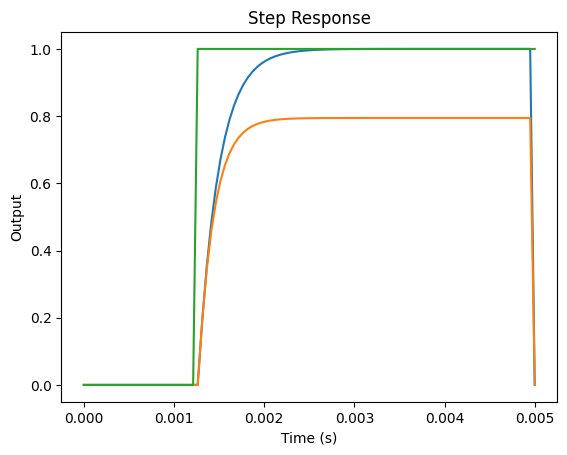

In [17]:
t = np.linspace(0, 5*Ts, 100)
r = np.append(np.zeros(int(len(t)/4)), np.ones(int(len(t)*3/4)))
n = len(sysd.A)

x = np.zeros((len(sysd.A),len(t))).reshape((n, len(t)))
x_cl = np.zeros((len(sysd.A),len(t)))
y = np.zeros(len(t))
y_cl = np.zeros(len(t))

for i in range(len(t)-1):
    x[:, i+1:i+2] = np.matmul(sysd.A,x[:, i:i+1]) + sysd.B*r[i]
    y[i] = np.matmul(sysd.C,x[:, i])
    
    x_cl[:, i+1:i+2] = np.matmul(sysd.A,x_cl[:, i:i+1]) + np.matmul(sysd.B,r[i]-np.matmul(K, x_cl[:, i]))
    y_cl[i] = np.matmul(sysd.C,x_cl[:, i])
#     u_cl[i] = r[i]-np.matmul(K, x_cl[:, i])



# Plot the step response

plt.plot(t, y)
plt.plot(t, y_cl)
plt.plot(t,r)
plt.title('Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.show()

## Error de estado estacionario

### Opción 1: Dividir la entrada por la ganancia en estado estacionario

Ganancia K0:  [[1.25873913]]


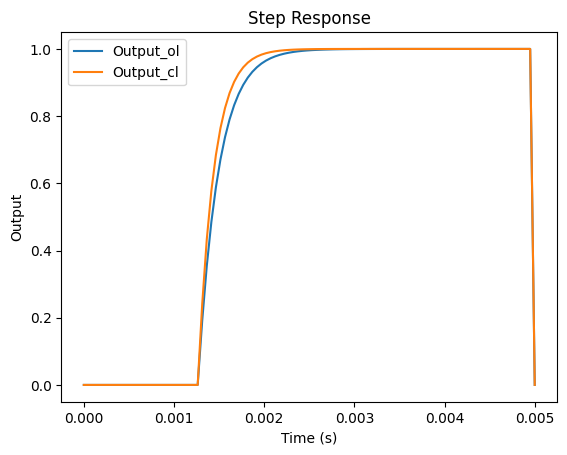

In [29]:
g = sysd.C*(np.eye(2)-(sysd.A-sysd.B*K))**(-1)*sysd.B
K0 = 1/g

print("Ganancia K0: ",K0)

t = np.linspace(0, 5*Ts, 100)
r = np.append(np.zeros(int(len(t)/4)), np.ones(int(len(t)*3/4)))
n = len(sysd.A)

x = np.zeros((len(sysd.A),len(t))).reshape((n, len(t)))
x_cl = np.zeros((len(sysd.A),len(t)))
y = np.zeros(len(t))
y_cl = np.zeros(len(t))

for i in range(len(t)-1):
    x[:, i+1:i+2] = np.matmul(sysd.A,x[:, i:i+1]) + sysd.B*r[i]
    y[i] = np.matmul(sysd.C,x[:, i])
    
    x_cl[:, i+1:i+2] = np.matmul(sysd.A,x_cl[:, i:i+1]) + np.matmul(sysd.B,K0*r[i]-np.matmul(K, x_cl[:, i]))
    y_cl[i] = np.matmul(sysd.C,x_cl[:, i])
#     u_cl[i] = r[i]-np.matmul(K, x_cl[:, i])

# Plot the step response
import matplotlib.pyplot as plt
plt.plot(t, y, label='Output_ol')
plt.plot(t, y_cl, label='Output_cl')
plt.legend(loc='best')
plt.title('Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.show()

In [24]:
t_r = calculate_rise_time(y,t)
print('Tiempo de subida en LA:',t_r)
print('Tiempo de subida deseado:',0.7*t_r)

Tiempo de subida en LA: 0.00047203186466654554
Tiempo de subida deseado: 0.00033042230526658184


In [28]:
tr_lc = calculate_rise_time(y_cl,t)
print('Tiempo de subida en LC:',tr_lc)

Tiempo de subida en LC: 0.0003535353535353534


### Opción 2: Agregar un integrador

$\begin{equation*}
        	\begin{bmatrix}
        		\dot{\boldsymbol{x}}\\\dot{x}_q 
        	\end{bmatrix}
            =
            \begin{bmatrix}
            	A & 0 \\ -C & 0
            \end{bmatrix}
             \begin{bmatrix}
        	    \boldsymbol{x} \\ x_q
            \end{bmatrix}
            +
            \begin{bmatrix}
            	B \\ 0
            \end{bmatrix}
            u
            +
            \begin{bmatrix}
            	0 \\ 1
            \end{bmatrix}
            r
        \end{equation*}$
        
$\begin{equation*}
          y = \begin{bmatrix}
            	C & 0
            \end{bmatrix}
                    \begin{bmatrix}
        	    \boldsymbol{x} \\ x_q
            \end{bmatrix}
        \end{equation*}$

 Otra forma de verlo:
 
$        \begin{equation*}
           \dot{\boldsymbol{x}}_e
            =
            \begin{bmatrix}
            	A & 0 \\ -C & 0
            \end{bmatrix}
            \boldsymbol{x}_e
            +
            \begin{bmatrix}
            	B & 0\\ 0 & 1
            \end{bmatrix}
            \boldsymbol{u}_e
       \end{equation*}$
       
$\begin{equation*}
          y = \begin{bmatrix}
            	C & 0
            \end{bmatrix}
        	    \boldsymbol{x}_e
        \end{equation*}$

In [23]:
Ae = np.concatenate((np.concatenate((sys.A , np.zeros((2,1))), axis=1), np.concatenate((-sys.C , np.zeros((1,1))), axis=1)), axis=0)

Be = np.concatenate((np.concatenate((sys.B, np.zeros((2, 1))), axis=1),
                     np.concatenate((np.zeros((1, 1)), np.ones((1, 1))), axis=1)), axis=0)


Br = [[0],[0],[1]]

# Be = np.concatenate((sys_ss.B,np.zeros((1, 1))),axis=0)

Ce = np.concatenate((sys.C, np.zeros((1,1))),axis = 1)

De = np.zeros((1,2))

Dr = np.zeros((1,1))

Cr = [[0, 1, 0]]

sys_e = co.ss(Ae,Be,Ce,De)

# print(Ae)
# print(Be)
print(Ce)
# print(De)
print(Br)
# print(sys_e)

K1 = co.place(sys_e.A, sys_e.B, [p1, p2,10*max(p1,p2)])
print(K)
print(K1)

ss_cl_e = co.ss(sys_e.A - sys_e.B @ K1, Br, Cr, Dr)

t, y_lce = co.step_response(ss_cl_e)

# Plot the step response
# import matplotlib.pyplot as plt
# # plt.plot(t, y_la)
# plt.plot(t, y_lce)
# plt.title('Step Response')
# plt.xlabel('Time (s)')
# plt.ylabel('Output')
# plt.show()

[[0. 1. 0.]]
[[0], [0], [1]]
[[0.12789971 0.13083942]]
[[ 19.17415632  -3.51188375   1.35101645]
 [578.27107942 -17.51600672 341.81344471]]
